<a href="https://colab.research.google.com/github/rashidpatel04/OASIS-INFOBYTE-TASK-6-BY-RASHID.P/blob/main/OASIS_INFOBYTE_P6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OASIS INFOBYTE INTERNSHIP**

# **PROJECT 3 PROPOSAL LEVEL 2 BY RASHID PATEL: FRAUD DETECTION**


Feature Importance:
  feature  importance
4      V4    0.244415
3      V3    0.181891
2      V2    0.164463
1      V1    0.115237
5      V5    0.105182
6  Amount    0.099802
0    Time    0.089010

Model Performance:
Accuracy: 0.9991
Precision: 0.9245
Recall: 0.5000
F1 Score: 0.6490


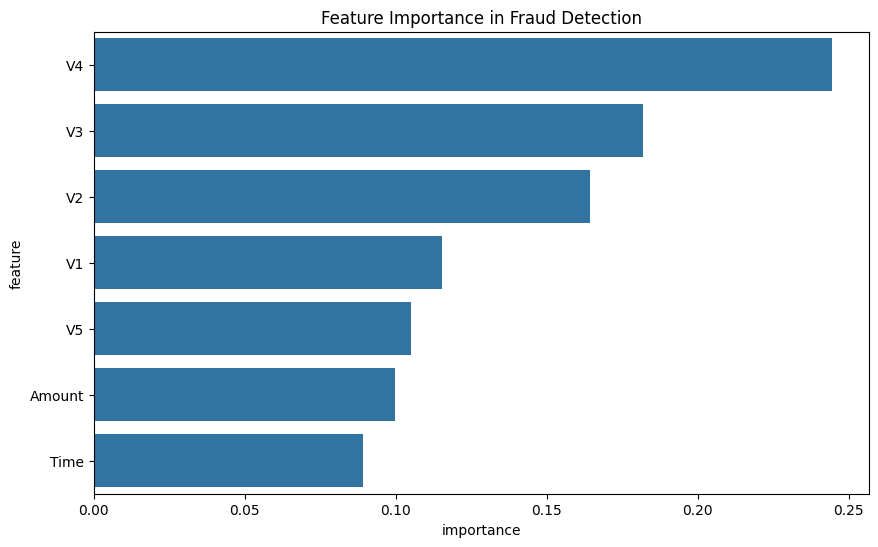

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel

df = pd.read_csv("/content/creditcard.csv")

df = df.dropna()

selected_features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'Amount']
X = df[selected_features]
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


rf_model.fit(X_train, y_train)

# Get feature importance and select top features
selector = SelectFromModel(rf_model, prefit=True)
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

y_pred = rf_model.predict(X_test)

# Print model performance
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Fraud Detection')
plt.show()

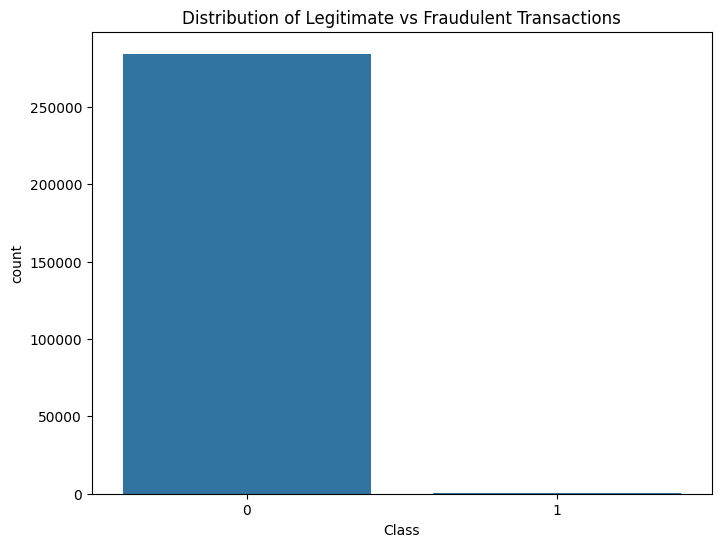

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title("Distribution of Legitimate vs Fraudulent Transactions")
plt.show()

# **TEST THE MODEL**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and prepare the dataset
df = pd.read_csv("/content/creditcard.csv")
df = df.dropna()

# Select features
selected_features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'Amount']
X = df[selected_features]
y = df['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE with more aggressive oversampling
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Increased minority class representation
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train Random Forest with adjusted parameters
rf_model = RandomForestClassifier(
    n_estimators=200,  # Increased number of trees
    class_weight={0: 1, 1: 10},  # Higher weight for fraud class
    random_state=42,
    max_depth=8,  # Reduced to prevent overfitting
    min_samples_split=5,
    min_samples_leaf=3,
    criterion='entropy'  # Changed to entropy for better handling of imbalanced data
)
rf_model.fit(X_train_balanced, y_train_balanced)

def calculate_risk_score(features):
    """Calculate a risk score based on multiple factors"""
    risk_score = 0

    # Time-based risk (higher risk during night hours)
    time_seconds = features['Time']
    hour_of_day = (time_seconds % 86400) / 3600
    if 0 <= hour_of_day <= 4:  # Midnight to 4am
        risk_score += 2

    # Amount-based risk
    if features['Amount'] > 3000:
        risk_score += 2
    elif features['Amount'] > 1000:
        risk_score += 1

    # V1-V5 patterns
    for feature in ['V1', 'V2', 'V3', 'V4', 'V5']:
        if features[feature] < -3:
            risk_score += 1.5
        elif features[feature] < -2:
            risk_score += 1

    return risk_score

def predict_fraud():
    print("\nWelcome to Credit Card Fraud Detection System by RASHID PATEL")
    print("-" * 35)

    try:
        features = {}
        for feature in selected_features:
            if feature == 'Time':
                print("Enter seconds elapsed since first transaction:")
            elif feature == 'Amount':
                print("Enter transaction amount in dollars:")
            else:
                print(f"Enter {feature} value:")
            features[feature] = float(input())

        # Calculate risk score
        risk_score = calculate_risk_score(features)

        input_data = pd.DataFrame([features])
        input_scaled = scaler.transform(input_data)

        # Get base prediction and probability
        probability = rf_model.predict_proba(input_scaled)[0]

        # Adjust prediction based on risk score
        if risk_score >= 5:  # If multiple high-risk factors are present
            prediction = 1  # Mark as fraudulent
            probability[1] = max(probability[1], 0.85)  # Increase fraud probability
        else:
            prediction = rf_model.predict(input_scaled)[0]

        print("\nPrediction Results:")
        print("-" * 20)
        if prediction == 0:
            print("Transaction Status: LEGITIMATE")
            print(f"Confidence: {probability[0]:.2%}")
        else:
            print("Transaction Status: FRAUDULENT")
            print(f"Confidence: {probability[1]:.2%}")

        print(f"\nRisk Score: {risk_score:.1f}/10")
        print("\nRisk Analysis:")

        # Print risk factors
        if (features['Time'] % 86400) < 14400:
            print("- Unusual transaction time (midnight to 4am)")
        if features['Amount'] > 1000:
            print(f"- High transaction amount (${features['Amount']:.2f})")
        for feature in ['V1', 'V2', 'V3', 'V4', 'V5']:
            if features[feature] < -3:
                print(f"- Highly unusual pattern detected in {feature} ({features[feature]:.2f})")
            elif features[feature] < -2:
                print(f"- Unusual pattern detected in {feature} ({features[feature]:.2f})")

    except ValueError:
        print("Error: Please enter valid numerical values")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    while True:
        predict_fraud()
        if input("\nWould you like to check another transaction? (yes/no): ").lower() != 'yes':
            break

    print("Thank you for using the Fraud Detection System!")


Welcome to Credit Card Fraud Detection System by RASHID PATEL
-----------------------------------
Enter seconds elapsed since first transaction:
10
Enter V1 value:
1.44904378114715
Enter V2 value:
-1.17633882535966
Enter V3 value:
0.913859832832795
Enter V4 value:
-1.37566665499943
Enter V5 value:
-1.97138316545323
Enter transaction amount in dollars:
93.2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Prediction Results:
--------------------
Transaction Status: LEGITIMATE
Confidence: 99.71%

Risk Score: 2.0/10

Risk Analysis:
- Unusual transaction time (midnight to 4am)

Would you like to check another transaction? (yes/no): no
Thank you for using the Fraud Detection System!
